In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# make X, y

In [6]:
DATE_TIME = "2021-11-18_20-39-00"

In [7]:
# get list 
list_path_sample_img = []
list_path_sample_img.extend(glob.glob(PATH_DATA_SAMPLE+"/"+DATE_TIME+ "/"+ "*.pklz"))

In [8]:
# create dataframe with two columns: 
## path_sample_img: image path in sample
## label: Healthy ou Sick
def make_dataFrame(list_path_sample_img: list) -> pd.DataFrame:

    df_sample_img = pd.DataFrame(columns = ["path_sample_img", "label"])
    for path_img in tqdm(list_path_sample_img):

        _, file_name, _ = utils.split_file_info(path_img)
        label = file_name[0]
        df_temporary = pd.DataFrame({"path_sample_img": path_img,
                                     "label": label}, index = [0])
        df_sample_img = pd.concat([df_sample_img, df_temporary])

    # randomise and reset index
    df_sample_img = df_sample_img.sample(frac=1).reset_index(drop = True)
    return df_sample_img

In [9]:
# set options 
pd.set_option('display.max_colwidth', None)
# to rest options
# pd.reset_option('^display.', silent=True)

In [10]:
df_sample_img = make_dataFrame(list_path_sample_img)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1750.54it/s]


In [11]:
df_sample_img.sample(5)

,path_sample_img,label
11085,../data/sample/2021-11-18_20-39-00\S_C130P91ThinF_IMG_20151004_135449_cell_125.pklz,S
18967,../data/sample/2021-11-18_20-39-00\H_C189P150ThinF_IMG_20151203_140902_cell_64.pklz,H
3850,../data/sample/2021-11-18_20-39-00\S_C99P60ThinF_IMG_20150918_141314_cell_116.pklz,S
11343,../data/sample/2021-11-18_20-39-00\H_C68P29N_ThinF_IMG_20150819_134326_cell_9.pklz,H
16996,../data/sample/2021-11-18_20-39-00\H_C241NThinF_IMG_20151207_124030_cell_142.pklz,H


In [12]:
# split train, validation, test set
df_path_sample_img_train, df_path_sample_img_test  = train_test_split(df_sample_img, test_size=0.2, random_state=1, \
                                                                          stratify=df_sample_img.label)

df_path_sample_img_train, df_path_sample_img_valid = train_test_split(df_path_sample_img_train, test_size=0.2, \
                                                                      random_state=1, stratify=df_path_sample_img_train.label)

In [13]:
# # split train, validation, test set
# list_path_sample_img_train, list_path_sample_img_test  = train_test_split(list_path_sample_img, test_size=0.2)
# list_path_sample_img_train, list_path_sample_img_valid = train_test_split(list_path_sample_img_train, test_size=0.2)

In [14]:
def make_Xy(list_path_sample_img: list) -> (np.array, np.array):
    X = np.ndarray( (len(list_path_sample_img), IMG_SIZE, IMG_SIZE, 3) ,dtype = "float16")
    y = np.array([""] * len(list_path_sample_img))
    for i, path in tqdm(enumerate(list_path_sample_img)):
        
        X[i] = utils.pickle_read(path).astype("float16")
    
        _, file_name, _ = utils.split_file_info(path)
        y[i] = file_name[0]
    
    return X, y
    

In [15]:
X_train, y_train  = make_Xy(df_path_sample_img_train.path_sample_img)

12800it [02:33, 83.60it/s] 


In [16]:
X_valid, y_valid  = make_Xy(df_path_sample_img_valid.path_sample_img)

3200it [00:34, 92.42it/s] 


In [17]:
X_test, y_test  = make_Xy(df_path_sample_img_test.path_sample_img)

4000it [00:40, 97.71it/s] 


In [18]:
# verification
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_test,  return_counts=True))

(array(['H', 'S'], dtype='<U1'), array([6400, 6400], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([1600, 1600], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([2000, 2000], dtype=int64))


In [19]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(12800, 64, 64, 3)
(3200, 64, 64, 3)
(4000, 64, 64, 3)


In [21]:
#assert false

# model_cnn

* Ref: https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60
* https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

In [22]:
BATCH_SIZE = 500
#percentage = 0.10
#BATCH_SIZE = int(len(X_train) * percentage)

NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [23]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [24]:
le = LabelEncoder()

In [25]:
y_train_enc = le.fit_transform(y_train)

In [26]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [27]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [28]:
#!pip uninstall tensorflow

Créer un fichier .reg avec les instructions suivantes :

===

Windows Registry Editor Version 5.00

[HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\FileSystem]
"LongPathsEnabled"=dword:00000001

---

Exécuter le .reg

In [29]:
#!pip install tensorflow

In [30]:
import tensorflow as tf

In [31]:
from keras.models import Sequential

In [32]:
#assert False

In [33]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

In [34]:
#assert false

In [43]:
def make_model(seq_num: int, drop_out_rate: float) -> Sequential:
    model_cnn_6 = Sequential(name="cnn_" + str(seq_num) + "_drop_out_" + str(drop_out_rate))
    model_cnn_6.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D",
                                         filters=32,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                         filters=64,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_2"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_3",
                                         filters=128,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_3", pool_size=(2,2)))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_3"))

    model_cnn_6.add(tf.keras.layers.Flatten(name="flatten"))
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden", units = 1024, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

    # compiler modele
    model_cnn_6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),\
                        loss ="binary_crossentropy", metrics=["accuracy"])

    return model_cnn_6

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
aug = ImageDataGenerator(rotation_range=359, \
                         zoom_range=0.15, \
                         width_shift_range=0.2, height_shift_range=0.2, \
                         shear_range=0.15, \
                         horizontal_flip=True, \
                         vertical_flip=True, \
                         fill_mode="nearest")

In [37]:
def get_classes(y_pred_proba: np.array, le:LabelEncoder) -> np.array:
    y_pred_class_num = np.rint(y_pred_proba).astype(int)
    y_pred_class_text = le.inverse_transform(y_pred_class_num.ravel())
    return y_pred_class_text

In [38]:
def get_metrics(y_test: np.array, y_pred: np.array)->(pd.DataFrame, pd.DataFrame):
    # create dataframe metrics
    df_metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), columns = ["H", "S"], 
             index=["Precion", "Recall", "F1", "Support"])
    # add average column    
    df_metrics["average_macro"] = precision_recall_fscore_support(y_test, y_pred, average = "macro")
    df_metrics = df_metrics.replace(np.nan, -999)
    sr_metrics = df_metrics.stack(dropna=False)

    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ["cm_H", "cm_S"], index = ["cm_H", "cm_S"])
    sr_confusion_matrix = df_confusion_matrix.stack()
    sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])
    
    return df_metrics, df_confusion_matrix

In [37]:
model_cnn_6 = make_model(6, 0.2)

In [38]:
model_cnn_6.summary()

Model: "cnn_6_drop_out_0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)

In [70]:
len(X_train) // BATCH_SIZE

25

In [41]:
# version chez mus
# tf.__version__ 
#2.6.0

In [42]:
# version chez René
# tf.__version__ 
#2.7.0

In [46]:
history_6 = model_cnn_6.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 51s 2s/step - loss: 3.8504 - accuracy: 0.5082 - val_loss: 0.6712 - val_accuracy: 0.5503
Epoch 2/25
25/25 [==============================] - 48s 2s/step - loss: 0.7033 - accuracy: 0.5396 - val_loss: 0.9816 - val_accuracy: 0.5053
Epoch 3/25
25/25 [==============================] - 48s 2s/step - loss: 0.6566 - accuracy: 0.6140 - val_loss: 1.7821 - val_accuracy: 0.5031
Epoch 4/25
25/25 [==============================] - 48s 2s/step - loss: 0.6423 - accuracy: 0.6355 - val_loss: 2.1795 - val_accuracy: 0.5041
Epoch 5/25
25/25 [==============================] - 48s 2s/step - loss: 0.6345 - accuracy: 0.6479 - val_loss: 2.2727 - val_accuracy: 0.5072
Epoch 6/25
25/25 [==============================] - 49s 2s/step - loss: 0.6312 - accuracy: 0.6508 - val_loss: 2.1158 - val_accuracy: 0.5081
Epoch 7/25
25/25 [==============================] - 49s 2s/step - loss: 0.6365 - accuracy: 0.6459 - val_loss: 1.3829 - val_accuracy: 0.5178
Epoch 8/25
25/25 [==

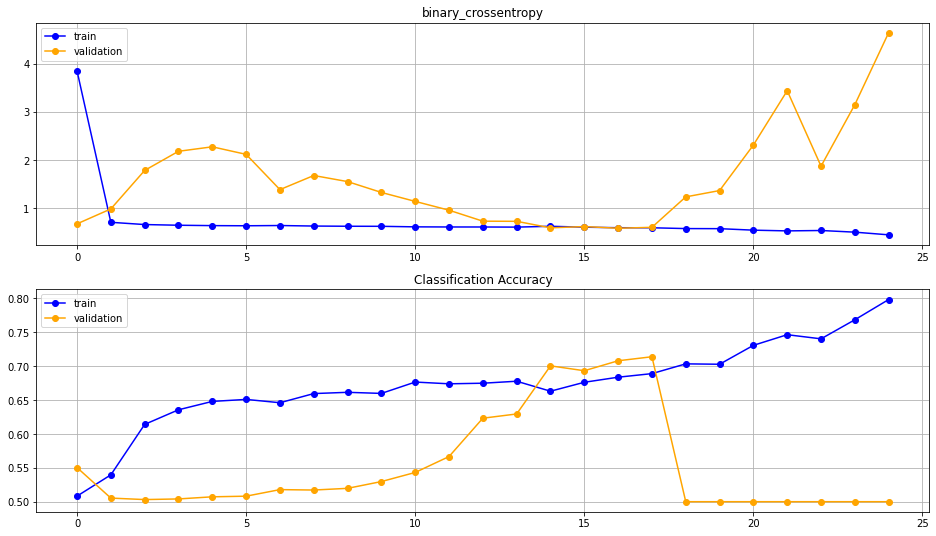

In [47]:
plot_history(history_6)

In [48]:
y_pred_proba = model_cnn_6.predict(X_test)

In [50]:
y_pred = get_classes(y_pred_proba, le)

Légende :
* H : Healthy
* S : Sick

In [80]:
type(y_pred)

numpy.ndarray

In [82]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

c:\users\rené\documents\rene\ia\ia297\jupyter\420-a62-bb_projetsynthese\projet_keras\keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rené\documents\rene\ia\ia297\jupyter\420-a62-bb_projetsynthese\projet_keras\keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
df_metrics

,H,S,average_macro
Precion,0.0,0.500000,0.250000
Recall,0.0,1.000000,0.500000
F1,0.0,0.666667,0.333333
Support,2000.0,2000.000000,-999.000000


In [84]:
df_confusion_matrix

,cm_H,cm_S
cm_H,0,2000
cm_S,0,2000


## Dropt out 0.1

In [88]:
model_cnn_7 = make_model(7, 0.1)

In [89]:
model_cnn_7.summary()

Model: "cnn_7_drop_out_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)

In [90]:
history_7 = model_cnn_7.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 48s 2s/step - loss: 3.0553 - accuracy: 0.5029 - val_loss: 0.6954 - val_accuracy: 0.5203
Epoch 2/25
25/25 [==============================] - 49s 2s/step - loss: 0.6799 - accuracy: 0.5760 - val_loss: 0.6473 - val_accuracy: 0.6375
Epoch 3/25
25/25 [==============================] - 51s 2s/step - loss: 0.6552 - accuracy: 0.6181 - val_loss: 0.6615 - val_accuracy: 0.6012
Epoch 4/25
25/25 [==============================] - 51s 2s/step - loss: 0.6352 - accuracy: 0.6520 - val_loss: 0.7774 - val_accuracy: 0.5544
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 0.6325 - accuracy: 0.6518 - val_loss: 0.9123 - val_accuracy: 0.5506
Epoch 6/25
25/25 [==============================] - 50s 2s/step - loss: 0.6469 - accuracy: 0.6363 - val_loss: 0.6201 - val_accuracy: 0.6669
Epoch 7/25
25/25 [==============================] - 50s 2s/step - loss: 0.6337 - accuracy: 0.6499 - val_loss: 0.6466 - val_accuracy: 0.6388
Epoch 8/25
25/25 [==

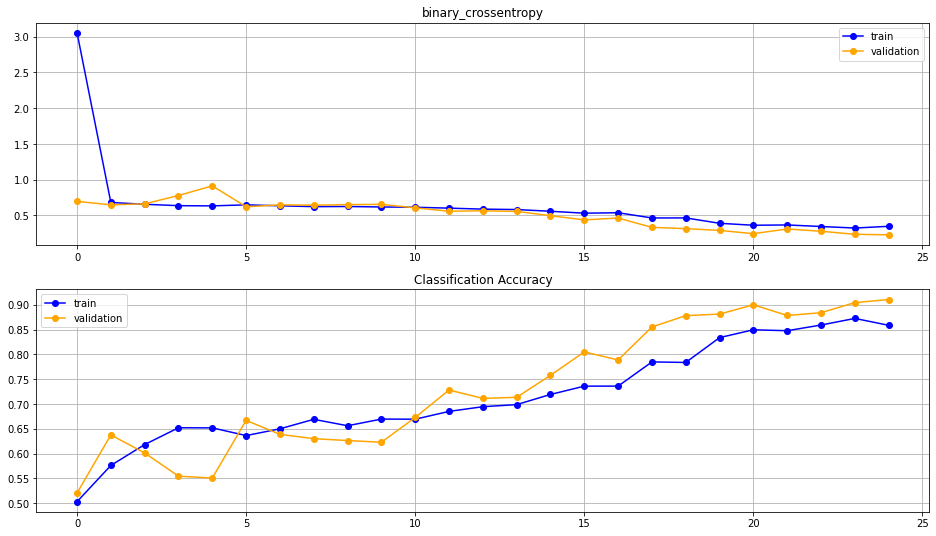

In [96]:
plot_history(history_7)

In [91]:
y_pred_proba = model_cnn_7.predict(X_test)

In [92]:
y_pred = get_classes(y_pred_proba, le)

In [93]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

In [94]:
df_metrics

,H,S,average_macro
Precion,0.904,0.904,0.904
Recall,0.904,0.904,0.904
F1,0.904,0.904,0.904
Support,2000.000,2000.000,-999.000


In [95]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1808,192
cm_S,192,1808


## Drop out 0.05

In [97]:
model_cnn_8 = make_model(8, 0.05)

In [99]:
model_cnn_8.summary()

Model: "cnn_8_drop_out_0.05"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128

In [100]:
history_8 = model_cnn_8.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 49s 2s/step - loss: 2.7777 - accuracy: 0.5026 - val_loss: 0.6961 - val_accuracy: 0.5075
Epoch 2/25
25/25 [==============================] - 47s 2s/step - loss: 0.6751 - accuracy: 0.5782 - val_loss: 0.6549 - val_accuracy: 0.6087
Epoch 3/25
25/25 [==============================] - 47s 2s/step - loss: 0.6490 - accuracy: 0.6315 - val_loss: 0.6221 - val_accuracy: 0.6609
Epoch 4/25
25/25 [==============================] - 47s 2s/step - loss: 0.6654 - accuracy: 0.5929 - val_loss: 0.6876 - val_accuracy: 0.5669
Epoch 5/25
25/25 [==============================] - 48s 2s/step - loss: 0.6377 - accuracy: 0.6463 - val_loss: 0.6487 - val_accuracy: 0.6347
Epoch 6/25
25/25 [==============================] - 48s 2s/step - loss: 0.6271 - accuracy: 0.6633 - val_loss: 0.6623 - val_accuracy: 0.6344
Epoch 7/25
25/25 [==============================] - 48s 2s/step - loss: 0.6140 - accuracy: 0.6706 - val_loss: 0.6858 - val_accuracy: 0.6272
Epoch 8/25
25/25 [==

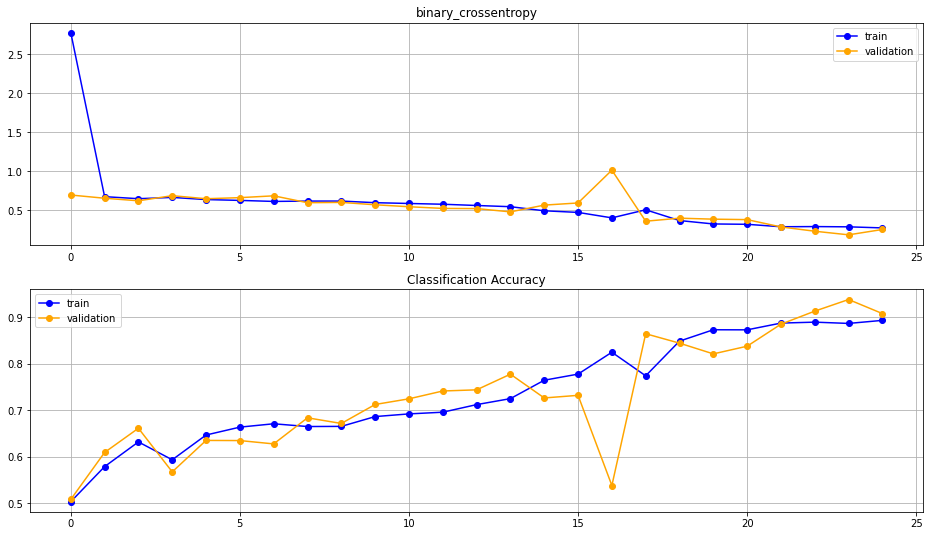

In [101]:
plot_history(history_8)

In [102]:
y_pred_proba = model_cnn_8.predict(X_test)

In [103]:
y_pred = get_classes(y_pred_proba, le)

In [104]:
df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)

In [105]:
df_metrics

,H,S,average_macro
Precion,0.940212,0.894313,0.917262
Recall,0.888500,0.943500,0.916000
F1,0.913625,0.918248,0.915936
Support,2000.000000,2000.000000,-999.000000


In [106]:
df_confusion_matrix

,cm_H,cm_S
cm_H,1777,223
cm_S,113,1887


# TODO

* Mettre des dropOut
* faire équivalent de predict_classes() qui n'existe plus dans tf nouvelle version.:
*   On pourra utiliser la proba retournée par model.predict, if >0.50 classe 1
* evaluer avec X_test et matrice de confusion
* reprendre les lignes de suivi des metriques avec MLFlow comme on a fait pour RandomForest
* sauvegarder model_cnn + X_train etc.. et push dans gdrive

In [ ]:
# # matrice de confusion
# from sklearn import metrics
# metrics.confusion_matrix(y_test_enc, y_pred, normalize="true")

In [ ]:
#Augmenter Batch Size = int(len(X_Tain) * %) + 1
#Reduire le learning rate

In [ ]:
#model_cnn_4.save(PATH_MODEL + "/model_cnn_4.h5")

Keras avec GPU AMD
https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce

# Tester dropout: seulement sur fully connected 

ref:
* https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
* https://stackoverflow.com/questions/46841362/where-dropout-should-be-inserted-fully-connected-layer-convolutional-layer#:~:text=3%20Answers&text=Usually%2C%20dropout%20is%20placed%20on,co%2Dadapting%20themselves%20causing%20overfitting.

In [39]:
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict(X_test)
    y_pred = get_classes(y_pred_proba, le)
    df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)
    display(df_metrics)
    display(df_confusion_matrix)

In [59]:
def make_model_v2(seq_num: int, drop_out_rate: float) -> Sequential:
    model_cnn_6 = Sequential(name="cnn_" + str(seq_num) + "_drop_out_" + str(drop_out_rate))
    model_cnn_6.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D",
                                         filters=32,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))
    #model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                         filters=64,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))
    #model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_2"))

    model_cnn_6.add(tf.keras.layers.Conv2D(name = "conv2D_3",
                                         filters=128,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn_6.add(tf.keras.layers.MaxPooling2D(name="pooling_3", pool_size=(2,2)))
    #model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_3"))

    model_cnn_6.add(tf.keras.layers.Flatten(name="flatten"))
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden", units = 1024, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_1"))
    
    model_cnn_6.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn_6.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_2"))
    model_cnn_6.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

    # compiler modele
    model_cnn_6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),\
                        loss ="binary_crossentropy", metrics=["accuracy"])

    return model_cnn_6

## Dropout 0.3

In [60]:
model_cnn_9 = make_model_v2(9, 0.30)

In [61]:
model_cnn_9.summary()

Model: "cnn_9_drop_out_0.3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)       

In [65]:
history_9 = model_cnn_9.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 96s 4s/step - loss: 2.5785 - accuracy: 0.4959 - val_loss: 0.6916 - val_accuracy: 0.5159
Epoch 2/25
25/25 [==============================] - 92s 4s/step - loss: 0.6794 - accuracy: 0.5735 - val_loss: 0.6452 - val_accuracy: 0.6237
Epoch 3/25
25/25 [==============================] - 93s 4s/step - loss: 0.6444 - accuracy: 0.6339 - val_loss: 0.6317 - val_accuracy: 0.6556
Epoch 4/25
25/25 [==============================] - 94s 4s/step - loss: 0.6542 - accuracy: 0.6176 - val_loss: 0.6380 - val_accuracy: 0.6359
Epoch 5/25
25/25 [==============================] - 93s 4s/step - loss: 0.6327 - accuracy: 0.6476 - val_loss: 0.6022 - val_accuracy: 0.6884
Epoch 6/25
25/25 [==============================] - 92s 4s/step - loss: 0.6291 - accuracy: 0.6493 - val_loss: 0.6088 - val_accuracy: 0.7009
Epoch 7/25
25/25 [==============================] - 90s 4s/step - loss: 0.6210 - accuracy: 0.6646 - val_loss: 0.6819 - val_accuracy: 0.5700
Epoch 8/25
25/25 [==

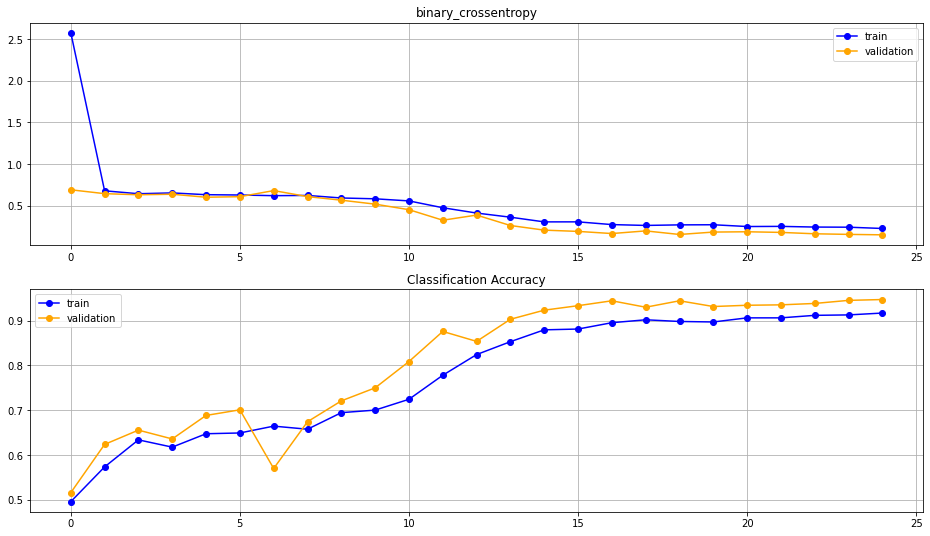

In [66]:
plot_history(history_9)

In [160]:
evaluate_model(model_cnn_9, X_test, y_test)

,H,S,average_macro
Precion,0.949297,0.945717,0.947507
Recall,0.945500,0.949500,0.947500
F1,0.947395,0.947605,0.947500
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1891,109
cm_S,101,1899


## Dropout 0.5

In [67]:
model_cnn_10 = make_model_v2(10, 0.50)

In [68]:
model_cnn_10.summary()

Model: "cnn_10_drop_out_0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)      

In [69]:
history_10 = model_cnn_10.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 92s 4s/step - loss: 2.1155 - accuracy: 0.5106 - val_loss: 0.6755 - val_accuracy: 0.5922
Epoch 2/25
25/25 [==============================] - 91s 4s/step - loss: 0.6928 - accuracy: 0.5611 - val_loss: 0.6498 - val_accuracy: 0.6334
Epoch 3/25
25/25 [==============================] - 91s 4s/step - loss: 0.6570 - accuracy: 0.6172 - val_loss: 0.6241 - val_accuracy: 0.6666
Epoch 4/25
25/25 [==============================] - 92s 4s/step - loss: 0.6439 - accuracy: 0.6341 - val_loss: 0.6137 - val_accuracy: 0.6916
Epoch 5/25
25/25 [==============================] - 91s 4s/step - loss: 0.6228 - accuracy: 0.6575 - val_loss: 0.5824 - val_accuracy: 0.7156
Epoch 6/25
25/25 [==============================] - 91s 4s/step - loss: 0.6001 - accuracy: 0.6866 - val_loss: 0.5459 - val_accuracy: 0.7378
Epoch 7/25
25/25 [==============================] - 91s 4s/step - loss: 0.5702 - accuracy: 0.7146 - val_loss: 0.4876 - val_accuracy: 0.7744
Epoch 8/25
25/25 [==

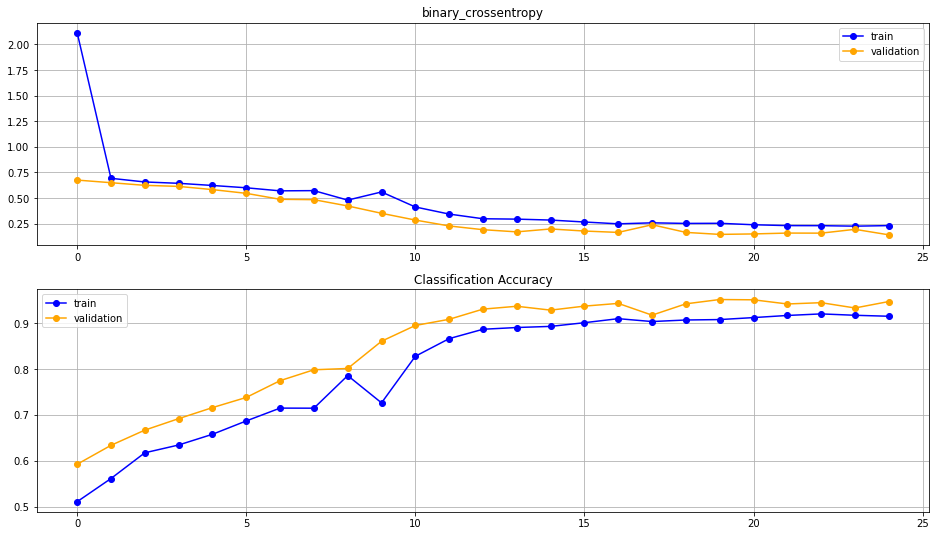

In [71]:
plot_history(history_10)

In [161]:
evaluate_model(model_cnn_10, X_test, y_test)

,H,S,average_macro
Precion,0.943238,0.954914,0.949076
Recall,0.955500,0.942500,0.949000
F1,0.949329,0.948666,0.948998
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1911,89
cm_S,115,1885


## Dropout 0.25

In [72]:
model_cnn_11 = make_model_v2(11, 0.250)

In [73]:
model_cnn_11.summary()

Model: "cnn_11_drop_out_0.25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)     

In [74]:
history_11 = model_cnn_11.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 94s 4s/step - loss: 2.7490 - accuracy: 0.4961 - val_loss: 0.6795 - val_accuracy: 0.5884
Epoch 2/25
25/25 [==============================] - 90s 4s/step - loss: 0.6835 - accuracy: 0.5667 - val_loss: 0.6489 - val_accuracy: 0.6066
Epoch 3/25
25/25 [==============================] - 91s 4s/step - loss: 0.6540 - accuracy: 0.6186 - val_loss: 0.6445 - val_accuracy: 0.6356
Epoch 4/25
25/25 [==============================] - 90s 4s/step - loss: 0.6487 - accuracy: 0.6317 - val_loss: 0.6215 - val_accuracy: 0.6503
Epoch 5/25
25/25 [==============================] - 91s 4s/step - loss: 0.6330 - accuracy: 0.6510 - val_loss: 0.6302 - val_accuracy: 0.6478
Epoch 6/25
25/25 [==============================] - 91s 4s/step - loss: 0.6233 - accuracy: 0.6642 - val_loss: 0.6441 - val_accuracy: 0.6250
Epoch 7/25
25/25 [==============================] - 91s 4s/step - loss: 0.6221 - accuracy: 0.6608 - val_loss: 0.6141 - val_accuracy: 0.6809
Epoch 8/25
25/25 [==

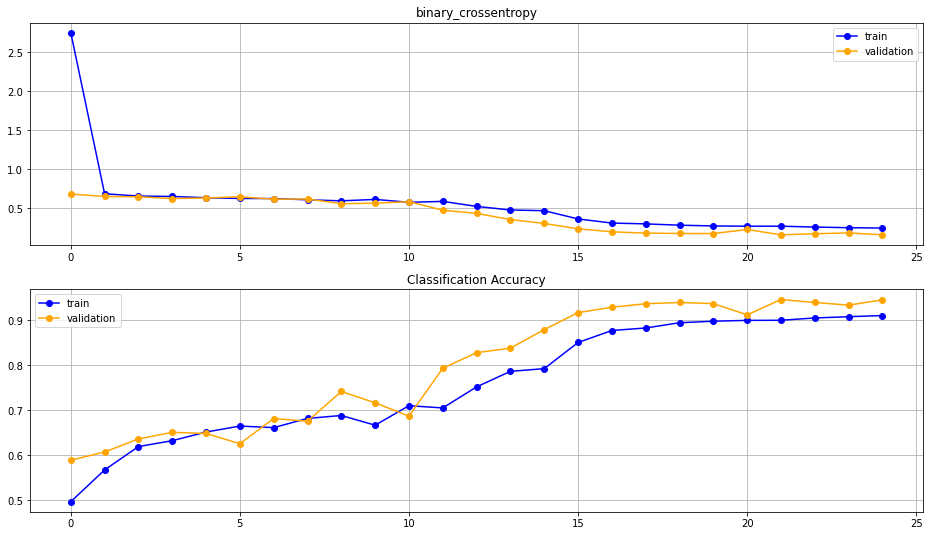

In [75]:
plot_history(history_11)

In [162]:
evaluate_model(model_cnn_11, X_test, y_test)

,H,S,average_macro
Precion,0.938894,0.966976,0.952935
Recall,0.968000,0.937000,0.952500
F1,0.953225,0.951752,0.952489
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1936,64
cm_S,126,1874


## Dropout 0.75

In [76]:
model_cnn_12 = make_model_v2(12, 0.750)

In [77]:
model_cnn_12.summary()

Model: "cnn_12_drop_out_0.75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)     

In [78]:
history_12 = model_cnn_12.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 99s 4s/step - loss: 0.2315 - accuracy: 0.9172 - val_loss: 0.1499 - val_accuracy: 0.9491
Epoch 2/25
25/25 [==============================] - 98s 4s/step - loss: 0.2400 - accuracy: 0.9128 - val_loss: 0.1489 - val_accuracy: 0.9472
Epoch 3/25
25/25 [==============================] - 91s 4s/step - loss: 0.2308 - accuracy: 0.9148 - val_loss: 0.1466 - val_accuracy: 0.9531
Epoch 4/25
25/25 [==============================] - 91s 4s/step - loss: 0.2264 - accuracy: 0.9164 - val_loss: 0.1505 - val_accuracy: 0.9503
Epoch 5/25
25/25 [==============================] - 90s 4s/step - loss: 0.2363 - accuracy: 0.9102 - val_loss: 0.1593 - val_accuracy: 0.9494
Epoch 6/25
25/25 [==============================] - 90s 4s/step - loss: 0.2385 - accuracy: 0.9128 - val_loss: 0.1497 - val_accuracy: 0.9491
Epoch 7/25
25/25 [==============================] - 91s 4s/step - loss: 0.2276 - accuracy: 0.9167 - val_loss: 0.1369 - val_accuracy: 0.9547
Epoch 8/25
25/25 [==

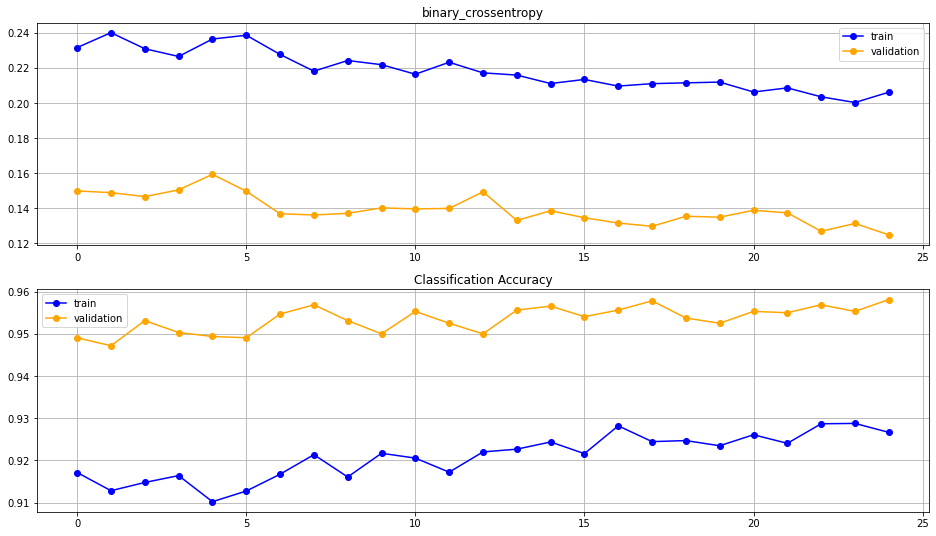

In [79]:
plot_history(history_12)

In [163]:
evaluate_model(model_cnn_12, X_test, y_test)

,H,S,average_macro
Precion,0.501130,0.764706,0.632918
Recall,0.998000,0.006500,0.502250
F1,0.667224,0.012890,0.340057
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1996,4
cm_S,1987,13


# Tester drop-out sur dernière couche de pooling

In [40]:
def make_model_v3(seq_num: int, drop_out_rate: float) -> Sequential:
    model_cnn = Sequential(name="cnn_" + str(seq_num) + "_drop_out_" + str(drop_out_rate))
    model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                         filters=32,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))

    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                         filters=64,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))

    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D_3",
                                         filters=128,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling_3", pool_size=(2,2)))
    model_cnn.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_3"))

    model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
    model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 1024, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    
    model_cnn.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

    # compiler modele
    model_cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),\
                        loss ="binary_crossentropy", metrics=["accuracy"])

    return model_cnn

In [41]:
## Dropout 0.25

In [42]:
model_cnn_13 = make_model_v3(13, 0.25)

In [43]:
model_cnn_13.summary()

Model: "cnn_13_drop_out_0.25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)

In [45]:
history_13 = model_cnn_13.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 60s 2s/step - loss: 2.8514 - accuracy: 0.5190 - val_loss: 0.6891 - val_accuracy: 0.5597
Epoch 2/25
25/25 [==============================] - 51s 2s/step - loss: 0.6509 - accuracy: 0.6196 - val_loss: 0.6460 - val_accuracy: 0.6288
Epoch 3/25
25/25 [==============================] - 50s 2s/step - loss: 0.6303 - accuracy: 0.6521 - val_loss: 0.6099 - val_accuracy: 0.6712
Epoch 4/25
25/25 [==============================] - 50s 2s/step - loss: 0.6109 - accuracy: 0.6720 - val_loss: 0.5819 - val_accuracy: 0.6934
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 0.6099 - accuracy: 0.6747 - val_loss: 0.5800 - val_accuracy: 0.7066
Epoch 6/25
25/25 [==============================] - 49s 2s/step - loss: 0.5727 - accuracy: 0.7081 - val_loss: 0.5357 - val_accuracy: 0.7337
Epoch 7/25
25/25 [==============================] - 49s 2s/step - loss: 0.5498 - accuracy: 0.7244 - val_loss: 0.4975 - val_accuracy: 0.7528
Epoch 8/25
25/25 [==

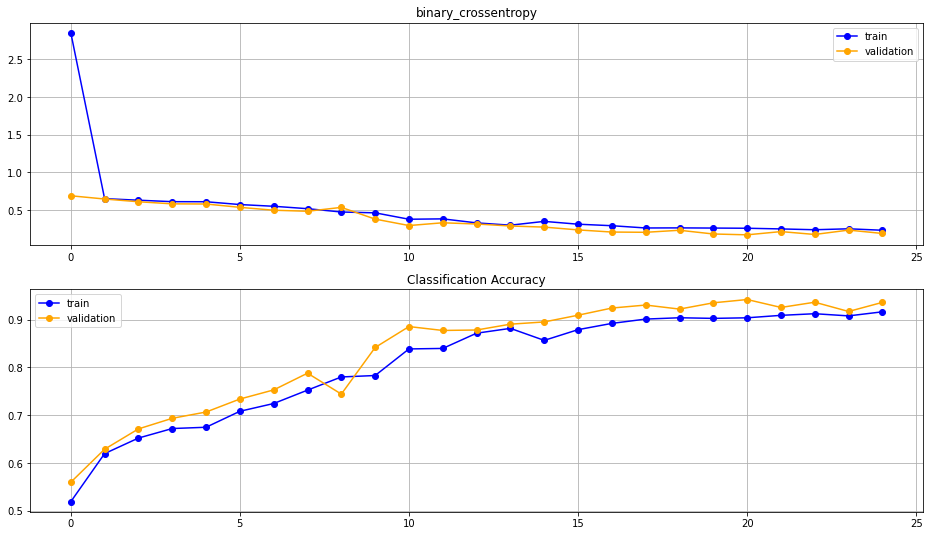

In [46]:
plot_history(history_13)

In [47]:
evaluate_model(model_cnn_13, X_test, y_test)

,H,S,average_macro
Precion,0.948133,0.916988,0.932561
Recall,0.914000,0.950000,0.932000
F1,0.930754,0.933202,0.931978
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1828,172
cm_S,100,1900


In [48]:
## Dropout 0.5

In [49]:
model_cnn_14 = make_model_v3(14, 0.5)

In [50]:
model_cnn_14.summary()

Model: "cnn_14_drop_out_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128) 

In [51]:
history_14 = model_cnn_14.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 50s 2s/step - loss: 2.2577 - accuracy: 0.5281 - val_loss: 0.6746 - val_accuracy: 0.5900
Epoch 2/25
25/25 [==============================] - 50s 2s/step - loss: 0.6411 - accuracy: 0.6382 - val_loss: 0.6341 - val_accuracy: 0.6344
Epoch 3/25
25/25 [==============================] - 49s 2s/step - loss: 0.6124 - accuracy: 0.6711 - val_loss: 0.6298 - val_accuracy: 0.6519
Epoch 4/25
25/25 [==============================] - 49s 2s/step - loss: 0.5955 - accuracy: 0.6896 - val_loss: 0.5741 - val_accuracy: 0.7069
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 0.5632 - accuracy: 0.7131 - val_loss: 0.5258 - val_accuracy: 0.7353
Epoch 6/25
25/25 [==============================] - 50s 2s/step - loss: 0.5375 - accuracy: 0.7219 - val_loss: 0.5376 - val_accuracy: 0.7322
Epoch 7/25
25/25 [==============================] - 50s 2s/step - loss: 0.4867 - accuracy: 0.7701 - val_loss: 0.4000 - val_accuracy: 0.8222
Epoch 8/25
25/25 [==

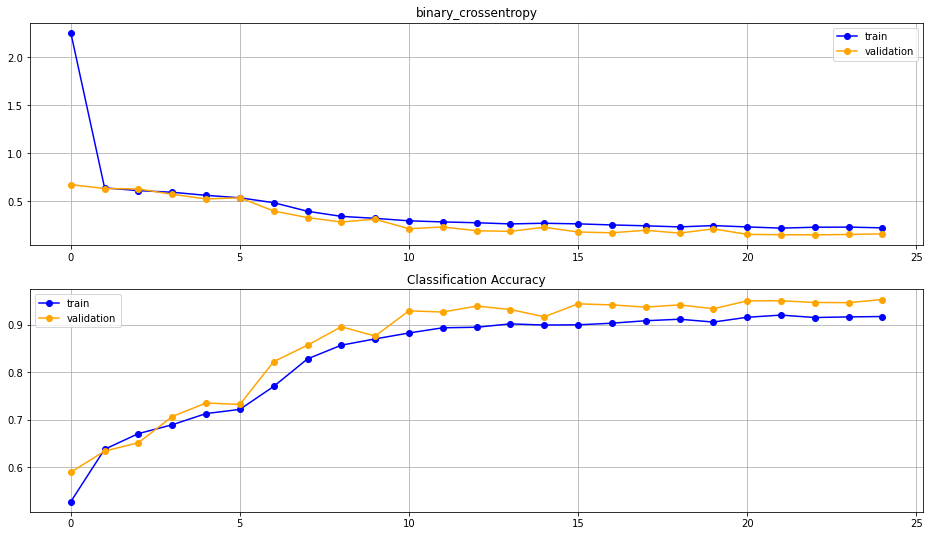

In [52]:
plot_history(history_14)

In [53]:
evaluate_model(model_cnn_14, X_test, y_test)

,H,S,average_macro
Precion,0.937377,0.949797,0.943587
Recall,0.950500,0.936500,0.943500
F1,0.943893,0.943102,0.943497
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1901,99
cm_S,127,1873


In [54]:
## Dropout 0.75

In [55]:
model_cnn_15 = make_model_v3(15, 0.75)

In [56]:
model_cnn_15.summary()

Model: "cnn_15_drop_out_0.75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pooling (MaxPooling2D)      (None, 32, 32, 32)        0         
                                                                 
 conv2D_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 16, 16, 64)        0         
                                                                 
 conv2D_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)

In [57]:
history_15 = model_cnn_15.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                        )

Epoch 1/25
25/25 [==============================] - 50s 2s/step - loss: 2.3299 - accuracy: 0.5223 - val_loss: 0.6975 - val_accuracy: 0.5481
Epoch 2/25
25/25 [==============================] - 50s 2s/step - loss: 0.6500 - accuracy: 0.6267 - val_loss: 0.6182 - val_accuracy: 0.6644
Epoch 3/25
25/25 [==============================] - 49s 2s/step - loss: 0.6299 - accuracy: 0.6571 - val_loss: 0.6137 - val_accuracy: 0.6647
Epoch 4/25
25/25 [==============================] - 48s 2s/step - loss: 0.6156 - accuracy: 0.6687 - val_loss: 0.5918 - val_accuracy: 0.6875
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 0.6102 - accuracy: 0.6726 - val_loss: 0.5717 - val_accuracy: 0.7000
Epoch 6/25
25/25 [==============================] - 54s 2s/step - loss: 0.5735 - accuracy: 0.7060 - val_loss: 0.5337 - val_accuracy: 0.7328
Epoch 7/25
25/25 [==============================] - 50s 2s/step - loss: 0.5313 - accuracy: 0.7377 - val_loss: 0.5450 - val_accuracy: 0.7181
Epoch 8/25
25/25 [==

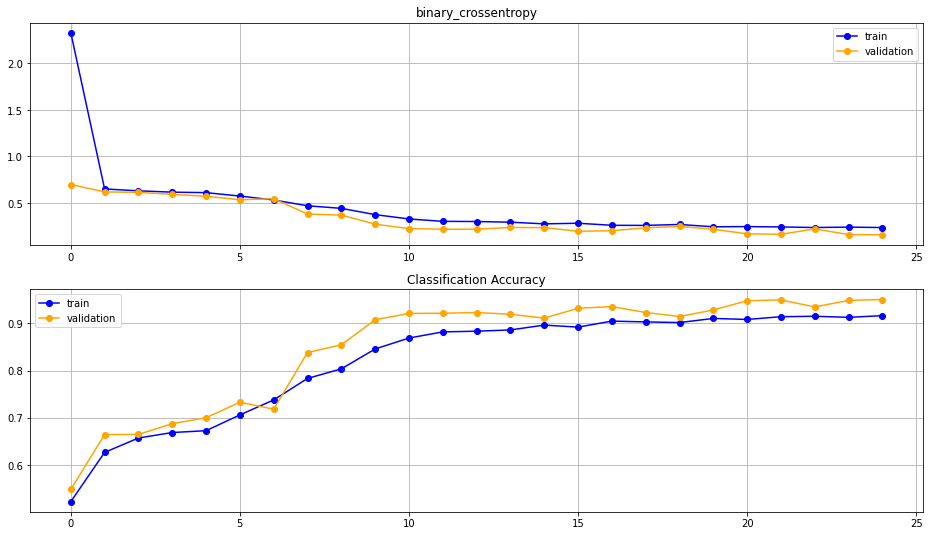

In [58]:
plot_history(history_15)

In [59]:
evaluate_model(model_cnn_15, X_test, y_test)

,H,S,average_macro
Precion,0.939245,0.957631,0.948438
Recall,0.958500,0.938000,0.948250
F1,0.948775,0.947714,0.948245
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1917,83
cm_S,124,1876


In [60]:
os.makedirs(PATH_MODEL, exist_ok=True)
utils.pickle_save(X_train, PATH_MODEL + "/" + f"X_train.pklz")
utils.pickle_save(X_test, PATH_MODEL + "/" + f"X_test.pklz")
utils.pickle_save(X_valid, PATH_MODEL + "/" + f"X_valid.pklz")

utils.pickle_save(y_train, PATH_MODEL + "/" + f"y_train.pklz")
utils.pickle_save(y_test, PATH_MODEL + "/" + f"y_test.pklz")
utils.pickle_save(y_valid, PATH_MODEL + "/" + f"y_valid.pklz")

On va garder le modèle qui a le meilleur recall pour le Sick.
Il serait prudent de faire plus d'essai en changeant les jeux et valider que cela reste vrai dans la moyenne.

In [61]:
model_cnn_13.save(PATH_MODEL + "/model_cnn_13.h5")